# Dynamic Programming

In this notebook, you will write your own implementations of many classical dynamic programming algorithms.  

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

---

### Part 0: Explore FrozenLakeEnv

We begin by importing the necessary packages.

In [1]:
import numpy as np
import copy

import check_test
from frozenlake import FrozenLakeEnv
from plot_utils import plot_values

Use the code cell below to create an instance of the [FrozenLake](https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py) environment.

In [2]:
env = FrozenLakeEnv()

The agent moves through a $4 \times 4$ gridworld, with states numbered as follows:
```
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
```
and the agent has 4 potential actions:
```
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
```

Thus, $\mathcal{S}^+ = \{0, 1, \ldots, 15\}$, and $\mathcal{A} = \{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [3]:
# print the state space and action space
print(env.observation_space)
print(env.action_space)

# print the total number of states and actions
print(env.nS)
print(env.nA)

Discrete(16)
Discrete(4)
16
4


Dynamic programming assumes that the agent has full knowledge of the MDP.  We have already amended the `frozenlake.py` file to make the one-step dynamics accessible to the agent.  

Execute the code cell below to return the one-step dynamics corresponding to a particular state and action.  In particular, `env.P[1][0]` returns the the probability of each possible reward and next state, if the agent is in state 1 of the gridworld and decides to go left.

In [4]:
env.P[14][2] # P(state, action)

[(0.3333333333333333, 14, 0.0, False),
 (0.3333333333333333, 15, 1.0, True),
 (0.3333333333333333, 10, 0.0, False)]

Each entry takes the form 
```
prob, next_state, reward, done
```
where: 
- `prob` details the conditional probability of the corresponding (`next_state`, `reward`) pair, and
- `done` is `True` if the `next_state` is a terminal state, and otherwise `False`.

Thus, we can interpret `env.P[1][0]` as follows:
$$
\mathbb{P}(S_{t+1}=s',R_{t+1}=r|S_t=1,A_t=0) = \begin{cases}
               \frac{1}{3} \text{ if } s'=1, r=0\\
               \frac{1}{3} \text{ if } s'=0, r=0\\
               \frac{1}{3} \text{ if } s'=5, r=0\\
               0 \text{ else}
            \end{cases}
$$

To understand the value of `env.P[1][0]`, note that when you create a FrozenLake environment, it takes as an (optional) argument `is_slippery`, which defaults to `True`.  

To see this, change the first line in the notebook from `env = FrozenLakeEnv()` to `env = FrozenLakeEnv(is_slippery=False)`.  Then, when you check `env.P[1][0]`, it should look like what you expect (i.e., `env.P[1][0] = [(1.0, 0, 0.0, False)]`).

The default value for the `is_slippery` argument is `True`, and so `env = FrozenLakeEnv()` is equivalent to `env = FrozenLakeEnv(is_slippery=True)`.  In the event that `is_slippery=True`, you see that this can result in the agent moving in a direction that it did not intend (where the idea is that the ground is *slippery*, and so the agent can slide to a location other than the one it wanted).

Feel free to change the code cell above to explore how the environment behaves in response to other (state, action) pairs.  

Before proceeding to the next part, make sure that you set `is_slippery=True`, so that your implementations below will work with the slippery environment!

In [5]:
### Global Variables
ent_psa = 0
ent_sprime = 1 
ent_r = 2
ent_done = 3
nS = env.nS
nA = env.nA
P = env.P

### Part 1: Iterative Policy Evaluation

In this section, you will write your own implementation of iterative policy evaluation.

Your algorithm should accept four arguments as **input**:
- `env`: This is an instance of an OpenAI Gym environment, where `env.P` returns the one-step dynamics.
- `policy`: This is a 2D numpy array with `policy.shape[0]` equal to the number of states (`env.nS`), and `policy.shape[1]` equal to the number of actions (`env.nA`).  `policy[s][a]` returns the probability that the agent takes action `a` while in state `s` under the policy.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).
- `theta`: This is a very small positive number that is used to decide if the estimate has sufficiently converged to the true value function (default value: `1e-8`).

The algorithm returns as **output**:
- `V`: This is a 1D numpy array with `V.shape[0]` equal to the number of states (`env.nS`).  `V[s]` contains the estimated value of state `s` under the input policy.

Please complete the function in the code cell below.

In [6]:
def q_sa_update(env, V, gamma=1.0):
    '''
    V: the current value estimate
    env: the environment (dynamics model)
    
    this function is somehow re-used latter... (v from q)
    '''
    # computing q_sa for a particular choice of (s,a)
    q_sa = np.zeros((nS,nA))
    
    for s in range(nS):
        for a in range(nA):
            nOut = len(P[s][a]) # # of possible outcomes of (s,a)
            for outcome in range(nOut):
                info_tran = P[s][a][outcome]
                s_prime = info_tran[ent_sprime]
                q_sa[s][a] += info_tran[ent_psa] * (info_tran[ent_r] + gamma * V[s_prime])
    #print(q_sa)
    return q_sa

In [7]:
def v_from_q(q_sa, policy):
    '''
    V(s) from q(s,a)
    i.e. compute v_p(s), the diagonal of the matrix product
    q_sa: nS-by-nA
    policy: nS-by-nA
    '''
    
    return np.diag(np.matmul(policy, q_sa.transpose())) 

In [8]:
def policy_evaluation(env, policy, gamma=1, theta=1e-8):
    V = np.zeros(env.nS)
    delta = 1
    n_iters = 0
    while delta > theta:
        V_old = V
        q_sa = q_sa_update(env, V, gamma) # the current estimat q_sa
        V = v_from_q(q_sa, policy)     
        delta = np.linalg.norm(V - V_old)
        n_iters+=1
    
    print('PE Finished at {}-th iteration'.format(n_iters))
    return V

We will evaluate the equiprobable random policy $\pi$, where $\pi(a|s) = \frac{1}{|\mathcal{A}(s)|}$ for all $s\in\mathcal{S}$ and $a\in\mathcal{A}(s)$.  

Use the code cell below to specify this policy in the variable `random_policy`.

In [9]:
random_policy = np.ones([env.nS, env.nA]) / env.nA

Run the next code cell to evaluate the equiprobable random policy and visualize the output.  The state-value function has been reshaped to match the shape of the gridworld.

PE Finished at 77-th iteration


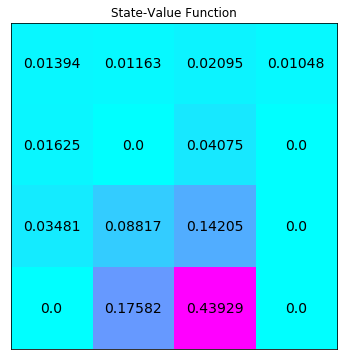

In [10]:
# evaluate the policy 
V = policy_evaluation(env, random_policy)

plot_values(V) # <= this function use random_policy as the global variables

Run the code cell below to test your function.  If the code cell returns **PASSED**, then you have implemented the function correctly!  

**Note:** In order to ensure accurate results, make sure that your `policy_evaluation` function satisfies the requirements outlined above (with four inputs, a single output, and with the default values of the input arguments unchanged).

In [11]:
check_test.run_check('policy_evaluation_check', policy_evaluation)

PE Finished at 77-th iteration


**<span style="color: green;">PASSED</span>**

notes:

$V(s)=\sum_a \pi(a|s) \sum_{(s^\prime, r)} p(s^\prime, r|a,s) (r + \gamma V(s^\prime))= \sum_a \pi(a|s) q(s,a)$

$V(s)= diagonal([\pi(a|s)]_{(s,a)} * [q(s,a)]^T_{(s,a)})$

In fact, Q(s,a) is compted during each iteration at the policy evaluation:
    - the v_from_q latter is redo the thing again after policy is evaluated

### Part 2: Obtain $q_\pi$ from $v_\pi$

In this section, you will write a function that takes the state-value function estimate as input, along with some state $s\in\mathcal{S}$.  It returns the **row in the action-value function** corresponding to the input state $s\in\mathcal{S}$.  That is, your function should accept as input both $v_\pi$ and $s$, and return $q_\pi(s,a)$ for all $a\in\mathcal{A}(s)$.

Your algorithm should accept four arguments as **input**:
- `env`: This is an instance of an OpenAI Gym environment, where `env.P` returns the one-step dynamics.
- `V`: This is a 1D numpy array with `V.shape[0]` equal to the number of states (`env.nS`).  `V[s]` contains the estimated value of state `s`.
- `s`: This is an integer corresponding to a state in the environment.  It should be a value between `0` and `(env.nS)-1`, inclusive.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as **output**:
- `q`: This is a 1D numpy array with `q.shape[0]` equal to the number of actions (`env.nA`).  `q[a]` contains the (estimated) value of state `s` and action `a`.

Please complete the function in the code cell below.

In [12]:
def q_from_v(env, V, s, gamma=1):
    q = np.zeros(env.nA)
    for a in range(env.nA):
        nOut = len(P[s][a]) # # of possible outcomes of (s,a)
        for outcome in range(nOut):
            info_tran = P[s][a][outcome]
            s_prime = info_tran[ent_sprime]
            q[a] += info_tran[ent_psa] * (info_tran[ent_r] + gamma * V[s_prime])
    
    return q

Run the code cell below to print the action-value function corresponding to the above state-value function.

In [13]:
Q = np.zeros([env.nS, env.nA])
for s in range(env.nS):
    Q[s] = q_from_v(env, V, s) 
print("Action-Value Function:")
print(Q)

Action-Value Function:
[[0.0147094  0.01393978 0.01393978 0.01317015]
 [0.00852356 0.01163091 0.01086129 0.01550788]
 [0.02444514 0.02095297 0.02406033 0.01435345]
 [0.01047648 0.01047648 0.00698432 0.01396864]
 [0.02166487 0.01701828 0.01624865 0.01006281]
 [0.         0.         0.         0.        ]
 [0.05433538 0.04735105 0.05433538 0.00698432]
 [0.         0.         0.         0.        ]
 [0.01701828 0.04099204 0.03480619 0.04640826]
 [0.07020885 0.1175599  0.10595784 0.05895312]
 [0.18940421 0.17582037 0.16001423 0.04297382]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.08799676 0.20503718 0.23442716 0.17582037]
 [0.25238823 0.53837051 0.52711478 0.43929117]
 [0.         0.         0.         0.        ]]


Run the code cell below to test your function.  If the code cell returns **PASSED**, then you have implemented the function correctly!  

**Note:** In order to ensure accurate results, make sure that the `q_from_v` function satisfies the requirements outlined above (with four inputs, a single output, and with the default values of the input arguments unchanged).

In [14]:
check_test.run_check('q_from_v_check', q_from_v)

**<span style="color: green;">PASSED</span>**

### Part 3: Policy Improvement

In this section, you will write your own implementation of policy improvement. 

Your algorithm should accept three arguments as **input**:
- `env`: This is an instance of an OpenAI Gym environment, where `env.P` returns the one-step dynamics.
- `V`: This is a 1D numpy array with `V.shape[0]` equal to the number of states (`env.nS`).  `V[s]` contains the estimated value of state `s`.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as **output**:
- `policy`: This is a 2D numpy array with `policy.shape[0]` equal to the number of states (`env.nS`), and `policy.shape[1]` equal to the number of actions (`env.nA`).  `policy[s][a]` returns the probability that the agent takes action `a` while in state `s` under the policy.

Please complete the function in the code cell below.  You are encouraged to use the `q_from_v` function you implemented above.

In [15]:
def row_hardmax(M):
    '''
    transform M by making max value each row to 1 and all the others zero
    '''
    row_maxes = M.max(axis=1).reshape(-1, 1)
    M_hmax = np.where(M == row_maxes, 1.0, 0.0) 
    return M_hmax

In [16]:
def row_softmax(M, alpha=50):
    '''
    transform M by making max value each row to 1 and all the others zero
    '''
    M_exped = np.exp(alpha * M)
    M_norm_constant = np.sum(M_exped, axis=1).reshape(M.shape[0], -1)
    M_smax = M_exped/M_norm_constant 
    
    return M_smax

In [17]:
def policy_improvement_softmax(env, V, gamma=1):
    q_sa = np.zeros((nS,nA))
    for s in range(nS):
        q_sa[s,:] = q_from_v(env, V, s, gamma=1)
    # to avoid repeated decisions, we add noise, the noise goes smallser during training
    policy = row_softmax(q_sa)
    return policy

In [18]:
# from solution (for checking)
def policy_improvement(env, V, gamma=1):
    policy = np.zeros([env.nS, env.nA]) / env.nA
    for s in range(env.nS):
        q = q_from_v(env, V, s, gamma)
        
        # OPTION 1: construct a deterministic policy 
        # policy[s][np.argmax(q)] = 1
        
        # OPTION 2: construct a stochastic policy that puts equal probability on maximizing actions
        best_a = np.argwhere(q==np.max(q)).flatten()
        policy[s] = np.sum([np.eye(env.nA)[i] for i in best_a], axis=0)/len(best_a)
        
    return policy

In [19]:
# show a improved policy using the current value function
p = policy_improvement(env, V, gamma=1)
print(p)

[[1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.   0.5  0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   1.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.   0.   1.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]]


Run the code cell below to test your function.  If the code cell returns **PASSED**, then you have implemented the function correctly!  

**Note:** In order to ensure accurate results, make sure that the `policy_improvement` function satisfies the requirements outlined above (with three inputs, a single output, and with the default values of the input arguments unchanged).

Before moving on to the next part of the notebook, you are strongly encouraged to check out the solution in **Dynamic_Programming_Solution.ipynb**.  There are many correct ways to approach this function!

In [20]:
check_test.run_check('policy_improvement_check', policy_improvement)

**<span style="color: green;">PASSED</span>**

### Part 4: Policy Iteration

In this section, you will write your own implementation of policy iteration.  The algorithm returns the optimal policy, along with its corresponding state-value function.

Your algorithm should accept three arguments as **input**:
- `env`: This is an instance of an OpenAI Gym environment, where `env.P` returns the one-step dynamics.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).
- `theta`: This is a very small positive number that is used to decide if the policy evaluation step has sufficiently converged to the true value function (default value: `1e-8`).

The algorithm returns as **output**:
- `policy`: This is a 2D numpy array with `policy.shape[0]` equal to the number of states (`env.nS`), and `policy.shape[1]` equal to the number of actions (`env.nA`).  `policy[s][a]` returns the probability that the agent takes action `a` while in state `s` under the policy.
- `V`: This is a 1D numpy array with `V.shape[0]` equal to the number of states (`env.nS`).  `V[s]` contains the estimated value of state `s`.

Please complete the function in the code cell below.  You are strongly encouraged to use the `policy_evaluation` and `policy_improvement` functions you implemented above.

In [21]:
def policy_iteration(env, gamma=1, theta=1e-8, softmax=False):
    policy_old = np.ones([env.nS, env.nA]) / env.nA 
    #V = np.zeros(env.nS)
    if softmax:
        n_iters = 20
    else:
        n_iters = 5
    ## TODO: complete the function
    for n_iter in range(n_iters):
        print("PI number {}".format(n_iter), " iteration:")
        V = policy_evaluation(env, policy_old, gamma=gamma, theta=theta)
        if softmax:
            policy = policy_improvement_softmax(env, V, gamma=gamma) 
        else:
            policy = policy_improvement(env, V, gamma=gamma) 
        policy_old = policy        
    
    return policy_old, V

Run the next code cell to solve the MDP and visualize the output.  The optimal state-value function has been reshaped to match the shape of the gridworld.

**Compare the optimal state-value function to the state-value function from Part 1 of this notebook**.  _Is the optimal state-value function consistently greater than or equal to the state-value function for the equiprobable random policy?_

PI number 0  iteration:
PE Finished at 77-th iteration
PI number 1  iteration:
PE Finished at 93-th iteration
PI number 2  iteration:
PE Finished at 144-th iteration
PI number 3  iteration:
PE Finished at 249-th iteration
PI number 4  iteration:
PE Finished at 408-th iteration
PI number 5  iteration:
PE Finished at 514-th iteration
PI number 6  iteration:
PE Finished at 671-th iteration
PI number 7  iteration:
PE Finished at 839-th iteration
PI number 8  iteration:
PE Finished at 967-th iteration
PI number 9  iteration:
PE Finished at 1047-th iteration
PI number 10  iteration:
PE Finished at 1092-th iteration
PI number 11  iteration:
PE Finished at 1116-th iteration
PI number 12  iteration:
PE Finished at 1128-th iteration
PI number 13  iteration:
PE Finished at 1134-th iteration
PI number 14  iteration:
PE Finished at 1137-th iteration
PI number 15  iteration:
PE Finished at 1138-th iteration
PI number 16  iteration:
PE Finished at 1139-th iteration
PI number 17  iteration:
PE Finishe

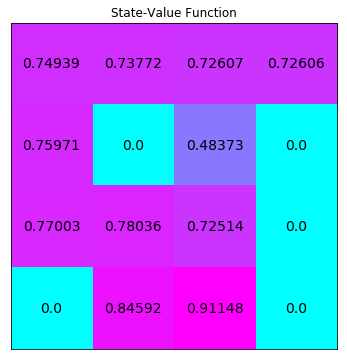

In [24]:
# (Mine) softmax PI
policy_pi, V_pi = policy_iteration(env, softmax=True)

# print the optimal policy
print("\nOptimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):")
print(policy_pi,"\n")

plot_values(V_pi)

PI number 0  iteration:
PE Finished at 77-th iteration
PI number 1  iteration:
PE Finished at 515-th iteration
PI number 2  iteration:
PE Finished at 648-th iteration
PI number 3  iteration:
PE Finished at 648-th iteration
PI number 4  iteration:
PE Finished at 648-th iteration

Optimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):
[[1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.   0.5  0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   1.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.   0.   1.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]] 



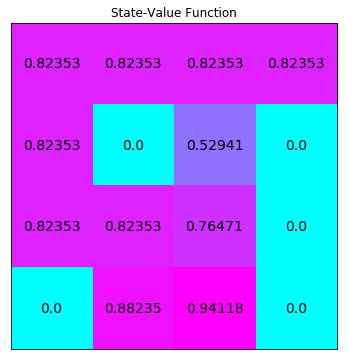

In [83]:
# obtain the optimal policy and optimal state-value function
policy_pi, V_pi = policy_iteration(env)

# print the optimal policy
print("\nOptimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):")
print(policy_pi,"\n")

plot_values(V_pi)

Run the code cell below to test your function.  If the code cell returns **PASSED**, then you have implemented the function correctly!  

**Note:** In order to ensure accurate results, make sure that the `policy_iteration` function satisfies the requirements outlined above (with three inputs, two outputs, and with the default values of the input arguments unchanged).

In [22]:
check_test.run_check('policy_iteration_check', policy_iteration)

PI number 0  iteration:
PE Finished at 77-th iteration
PI number 1  iteration:
PE Finished at 515-th iteration
PI number 2  iteration:
PE Finished at 648-th iteration
PI number 3  iteration:
PE Finished at 648-th iteration
PI number 4  iteration:
PE Finished at 648-th iteration


**<span style="color: green;">PASSED</span>**

### Part 5: Truncated Policy Iteration

In this section, you will write your own implementation of truncated policy iteration.  

You will begin by implementing truncated policy evaluation.  Your algorithm should accept five arguments as **input**:
- `env`: This is an instance of an OpenAI Gym environment, where `env.P` returns the one-step dynamics.
- `policy`: This is a 2D numpy array with `policy.shape[0]` equal to the number of states (`env.nS`), and `policy.shape[1]` equal to the number of actions (`env.nA`).  `policy[s][a]` returns the probability that the agent takes action `a` while in state `s` under the policy.
- `V`: This is a 1D numpy array with `V.shape[0]` equal to the number of states (`env.nS`).  `V[s]` contains the estimated value of state `s`.
- `max_it`: This is a positive integer that corresponds to the number of sweeps through the state space (default value: `1`).
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as **output**:
- `V`: This is a 1D numpy array with `V.shape[0]` equal to the number of states (`env.nS`).  `V[s]` contains the estimated value of state `s`.

Please complete the function in the code cell below.

In [48]:
def truncated_policy_evaluation(env, policy, V, max_it=1, gamma=1):
    # idea: to save iteration time, we use a good initializing V (our current estimate) to run 
    # a fixed number of iterations
    for it in range(max_it):
        V_old = V
        q_sa = q_sa_update(env, V, gamma) # the current estimat q_sa
        V = v_from_q(q_sa, policy)     
    
    return V

Next, you will implement truncated policy iteration.  Your algorithm should accept five arguments as **input**:
- `env`: This is an instance of an OpenAI Gym environment, where `env.P` returns the one-step dynamics.
- `max_it`: This is a positive integer that corresponds to the number of sweeps through the state space (default value: `1`).
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).
- `theta`: This is a very small positive number that is used for the stopping criterion (default value: `1e-8`).

The algorithm returns as **output**:
- `policy`: This is a 2D numpy array with `policy.shape[0]` equal to the number of states (`env.nS`), and `policy.shape[1]` equal to the number of actions (`env.nA`).  `policy[s][a]` returns the probability that the agent takes action `a` while in state `s` under the policy.
- `V`: This is a 1D numpy array with `V.shape[0]` equal to the number of states (`env.nS`).  `V[s]` contains the estimated value of state `s`.

Please complete the function in the code cell below.

In [49]:
def truncated_policy_iteration(env, max_it=1, gamma=1, theta=1e-8):
    V = np.zeros(env.nS)
    policy = np.zeros([env.nS, env.nA]) / env.nA
    delta = 1
    n_iter = 1
    ## TODO: complete the function
    
    while delta > theta:
        print("truncated_PI (max_it={}) {}-th".format(max_it, n_iter), " iteration:")
        policy = policy_improvement(env, V, gamma=gamma)
        V_old = V
        V = truncated_policy_evaluation(env, policy, V, max_it, gamma)
        delta = np.linalg.norm(V - V_old, ord=1)
        n_iter+=1
    return policy, V

Run the next code cell to solve the MDP and visualize the output.  The state-value function has been reshaped to match the shape of the gridworld.

Play with the value of the `max_it` argument.  Do you always end with the optimal state-value function?

truncated_PI (max_it=2) 1-th  iteration:
truncated_PI (max_it=2) 2-th  iteration:
truncated_PI (max_it=2) 3-th  iteration:
truncated_PI (max_it=2) 4-th  iteration:
truncated_PI (max_it=2) 5-th  iteration:
truncated_PI (max_it=2) 6-th  iteration:
truncated_PI (max_it=2) 7-th  iteration:
truncated_PI (max_it=2) 8-th  iteration:
truncated_PI (max_it=2) 9-th  iteration:
truncated_PI (max_it=2) 10-th  iteration:
truncated_PI (max_it=2) 11-th  iteration:
truncated_PI (max_it=2) 12-th  iteration:
truncated_PI (max_it=2) 13-th  iteration:
truncated_PI (max_it=2) 14-th  iteration:
truncated_PI (max_it=2) 15-th  iteration:
truncated_PI (max_it=2) 16-th  iteration:
truncated_PI (max_it=2) 17-th  iteration:
truncated_PI (max_it=2) 18-th  iteration:
truncated_PI (max_it=2) 19-th  iteration:
truncated_PI (max_it=2) 20-th  iteration:
truncated_PI (max_it=2) 21-th  iteration:
truncated_PI (max_it=2) 22-th  iteration:
truncated_PI (max_it=2) 23-th  iteration:
truncated_PI (max_it=2) 24-th  iteration:
t

truncated_PI (max_it=2) 282-th  iteration:
truncated_PI (max_it=2) 283-th  iteration:
truncated_PI (max_it=2) 284-th  iteration:
truncated_PI (max_it=2) 285-th  iteration:
truncated_PI (max_it=2) 286-th  iteration:
truncated_PI (max_it=2) 287-th  iteration:
truncated_PI (max_it=2) 288-th  iteration:
truncated_PI (max_it=2) 289-th  iteration:
truncated_PI (max_it=2) 290-th  iteration:
truncated_PI (max_it=2) 291-th  iteration:
truncated_PI (max_it=2) 292-th  iteration:
truncated_PI (max_it=2) 293-th  iteration:
truncated_PI (max_it=2) 294-th  iteration:
truncated_PI (max_it=2) 295-th  iteration:
truncated_PI (max_it=2) 296-th  iteration:
truncated_PI (max_it=2) 297-th  iteration:
truncated_PI (max_it=2) 298-th  iteration:
truncated_PI (max_it=2) 299-th  iteration:
truncated_PI (max_it=2) 300-th  iteration:
truncated_PI (max_it=2) 301-th  iteration:
truncated_PI (max_it=2) 302-th  iteration:
truncated_PI (max_it=2) 303-th  iteration:
truncated_PI (max_it=2) 304-th  iteration:
truncated_P

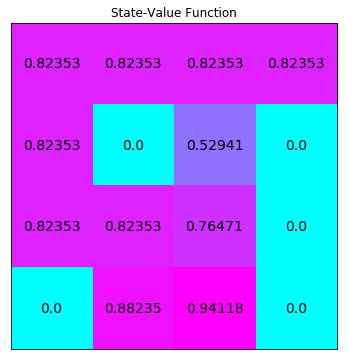

In [50]:
policy_tpi, V_tpi = truncated_policy_iteration(env, max_it=2)

# print the optimal policy
print("\nOptimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):")
print(policy_tpi,"\n")

# plot the optimal state-value function
plot_values(V_tpi)

Run the code cell below to test your function.  If the code cell returns **PASSED**, then you have implemented the function correctly!  

**Note:** In order to ensure accurate results, make sure that the `truncated_policy_iteration` function satisfies the requirements outlined above (with four inputs, two outputs, and with the default values of the input arguments unchanged).

In [51]:
check_test.run_check('truncated_policy_iteration_check', truncated_policy_iteration)

truncated_PI (max_it=1) 1-th  iteration:
truncated_PI (max_it=1) 2-th  iteration:
truncated_PI (max_it=1) 3-th  iteration:
truncated_PI (max_it=1) 4-th  iteration:
truncated_PI (max_it=1) 5-th  iteration:
truncated_PI (max_it=1) 6-th  iteration:
truncated_PI (max_it=1) 7-th  iteration:
truncated_PI (max_it=1) 8-th  iteration:
truncated_PI (max_it=1) 9-th  iteration:
truncated_PI (max_it=1) 10-th  iteration:
truncated_PI (max_it=1) 11-th  iteration:
truncated_PI (max_it=1) 12-th  iteration:
truncated_PI (max_it=1) 13-th  iteration:
truncated_PI (max_it=1) 14-th  iteration:
truncated_PI (max_it=1) 15-th  iteration:
truncated_PI (max_it=1) 16-th  iteration:
truncated_PI (max_it=1) 17-th  iteration:
truncated_PI (max_it=1) 18-th  iteration:
truncated_PI (max_it=1) 19-th  iteration:
truncated_PI (max_it=1) 20-th  iteration:
truncated_PI (max_it=1) 21-th  iteration:
truncated_PI (max_it=1) 22-th  iteration:
truncated_PI (max_it=1) 23-th  iteration:
truncated_PI (max_it=1) 24-th  iteration:
t

truncated_PI (max_it=1) 318-th  iteration:
truncated_PI (max_it=1) 319-th  iteration:
truncated_PI (max_it=1) 320-th  iteration:
truncated_PI (max_it=1) 321-th  iteration:
truncated_PI (max_it=1) 322-th  iteration:
truncated_PI (max_it=1) 323-th  iteration:
truncated_PI (max_it=1) 324-th  iteration:
truncated_PI (max_it=1) 325-th  iteration:
truncated_PI (max_it=1) 326-th  iteration:
truncated_PI (max_it=1) 327-th  iteration:
truncated_PI (max_it=1) 328-th  iteration:
truncated_PI (max_it=1) 329-th  iteration:
truncated_PI (max_it=1) 330-th  iteration:
truncated_PI (max_it=1) 331-th  iteration:
truncated_PI (max_it=1) 332-th  iteration:
truncated_PI (max_it=1) 333-th  iteration:
truncated_PI (max_it=1) 334-th  iteration:
truncated_PI (max_it=1) 335-th  iteration:
truncated_PI (max_it=1) 336-th  iteration:
truncated_PI (max_it=1) 337-th  iteration:
truncated_PI (max_it=1) 338-th  iteration:
truncated_PI (max_it=1) 339-th  iteration:
truncated_PI (max_it=1) 340-th  iteration:
truncated_P

truncated_PI (max_it=1) 652-th  iteration:
truncated_PI (max_it=1) 653-th  iteration:
truncated_PI (max_it=1) 654-th  iteration:
truncated_PI (max_it=1) 655-th  iteration:
truncated_PI (max_it=1) 656-th  iteration:
truncated_PI (max_it=1) 657-th  iteration:
truncated_PI (max_it=1) 658-th  iteration:
truncated_PI (max_it=1) 659-th  iteration:
truncated_PI (max_it=1) 660-th  iteration:
truncated_PI (max_it=1) 661-th  iteration:
truncated_PI (max_it=1) 662-th  iteration:
truncated_PI (max_it=1) 663-th  iteration:
truncated_PI (max_it=1) 664-th  iteration:
truncated_PI (max_it=1) 665-th  iteration:
truncated_PI (max_it=1) 666-th  iteration:
truncated_PI (max_it=1) 667-th  iteration:
truncated_PI (max_it=1) 668-th  iteration:
truncated_PI (max_it=1) 669-th  iteration:
truncated_PI (max_it=1) 670-th  iteration:
truncated_PI (max_it=1) 671-th  iteration:
truncated_PI (max_it=1) 672-th  iteration:
truncated_PI (max_it=1) 673-th  iteration:
truncated_PI (max_it=1) 674-th  iteration:
truncated_P

**<span style="color: green;">PASSED</span>**

### Part 6: Value Iteration

In this section, you will write your own implementation of value iteration.

Your algorithm should accept three arguments as input:
- `env`: This is an instance of an OpenAI Gym environment, where `env.P` returns the one-step dynamics.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).
- `theta`: This is a very small positive number that is used for the stopping criterion (default value: `1e-8`).

The algorithm returns as **output**:
- `policy`: This is a 2D numpy array with `policy.shape[0]` equal to the number of states (`env.nS`), and `policy.shape[1]` equal to the number of actions (`env.nA`).  `policy[s][a]` returns the probability that the agent takes action `a` while in state `s` under the policy.
- `V`: This is a 1D numpy array with `V.shape[0]` equal to the number of states (`env.nS`).  `V[s]` contains the estimated value of state `s`.

In [ ]:
def value_iteration(env, gamma=1, theta=1e-8):
    V = np.zeros(env.nS)
    
    ## TODO: complete the function
    
    return policy, V

Use the next code cell to solve the MDP and visualize the output.  The state-value function has been reshaped to match the shape of the gridworld.

In [ ]:
policy_vi, V_vi = value_iteration(env)

# print the optimal policy
print("\nOptimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):")
print(policy_vi,"\n")

# plot the optimal state-value function
plot_values(V_vi)

Run the code cell below to test your function.  If the code cell returns **PASSED**, then you have implemented the function correctly!  

**Note:** In order to ensure accurate results, make sure that the `value_iteration` function satisfies the requirements outlined above (with three inputs, two outputs, and with the default values of the input arguments unchanged).

In [ ]:
check_test.run_check('value_iteration_check', value_iteration)